# Homework 2
### Alex Simonoff

Prof. Cho - DS-GA 1011 | Natural Language Processing with Representation Learning

Much of the code and structure is from Lab 4

Help was given by TAs in office hours

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import csv
import pandas as pd
import matplotlib.pyplot as plt

random.seed(328)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

In [6]:
mnli_train = pd.read_csv('../hw2_data/mnli_train.tsv', sep="\t")
snli_train = pd.read_csv('../hw2_data/snli_train.tsv', sep="\t")
mnli_val = pd.read_csv('../hw2_data/mnli_val.tsv', sep="\t")
snli_val = pd.read_csv('../hw2_data/snli_val.tsv', sep="\t")

In [7]:
print("SNLI Training Examples: "+str(len(snli_train)))
print("SNLI Validation Examples: "+str(len(snli_val)))
print("MNLI Training Examples: "+str(len(mnli_train)))
print("MNLI Validation Examples: "+str(len(mnli_val)))

SNLI Training Examples: 100000
SNLI Validation Examples: 1000
MNLI Training Examples: 20000
MNLI Validation Examples: 5000


In [8]:
# shuffle to pull a random sample for testing
mnli_train = mnli_train.sample(frac=1).reset_index(drop=True)
snli_train = snli_train.sample(frac=1).reset_index(drop=True)

snli_test = snli_train[:20000]
mnli_test = mnli_train[:4000]
snli_train = snli_train[20000:].reset_index(drop=True)
mnli_train = mnli_train[4000:].reset_index(drop=True)

In [9]:
print("SNLI Training Examples: "+str(len(snli_train)))
print("SNLI Testing Examples: "+str(len(snli_test)))
print("SNLI Validation Examples: "+str(len(snli_val)))
print("MNLI Training Examples: "+str(len(mnli_train)))
print("MNLI Testing Examples: "+str(len(mnli_test)))
print("MNLI Validation Examples: "+str(len(mnli_val)))

SNLI Training Examples: 80000
SNLI Testing Examples: 20000
SNLI Validation Examples: 1000
MNLI Training Examples: 16000
MNLI Testing Examples: 4000
MNLI Validation Examples: 5000


In [10]:
# Loading word embeddings

# ADD TO HW LATEX REPORT
# @inproceedings{mikolov2018advances,
#   title={Advances in Pre-Training Distributed Word Representations},
#   author={Mikolov, Tomas and Grave, Edouard and Bojanowski, Piotr and Puhrsch, Christian and Joulin, Armand},
#   booktitle={Proceedings of the International Conference on Language Resources and Evaluation (LREC 2018)},
#   year={2018}
# }

import io
words_to_load = 50000

with open('../wiki-news-300d-1M.vec') as f:
    loaded_embeddings = np.zeros((words_to_load+2, 300))
    words = {}
    idx2words = {}
    ordered_words = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings[i+2, :] = np.asarray(s[1:])
        words[s[0]] = i+2
        idx2words[i+2] = s[0]
        ordered_words.append(s[0])

loaded_embeddings[0] = np.zeros(300,)
loaded_embeddings[1] = np.random.rand(300,)
words['PAD']=0
words['UNK']=1
idx2words[0]='PAD'
idx2words[1]='UNK'
ordered_words = ['PAD', 'UNK'] + ordered_words

In [11]:
import spacy
import string

punctuations = string.punctuation
tokenizer_sm = spacy.load('en_core_web_sm')

def tokenize(sentence):
    tokens = tokenizer_sm(sentence)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

In [12]:
def tokenize_dataset(dataset):
    token_dataset = []
    all_tokens = []
    for sample in dataset:
        tokens = tokenize(sample)
        all_tokens += tokens
        token_dataset.append(tokens)
    return token_dataset, all_tokens

In [14]:
#tokenized_dataset1, all_tokens1 = tokenize_dataset(snli_train.sentence1)
#tokenized_dataset2, all_tokens2 = tokenize_dataset(snli_train.sentence2)
#tokenized_dataset1_test, _ = tokenize_dataset(snli_test.sentence1)
#tokenized_dataset2_test, _ = tokenize_dataset(snli_test.sentence2)
#tokenized_dataset1_val, _ = tokenize_dataset(snli_val.sentence1)
#tokenized_dataset2_val, _ = tokenize_dataset(snli_val.sentence2)
#m_tokenized_dataset1, m_all_tokens1 = tokenize_dataset(mnli_train.sentence1)
#m_tokenized_dataset2, m_all_tokens2 = tokenize_dataset(mnli_train.sentence2)
#m_tokenized_dataset1_test, _ = tokenize_dataset(mnli_test.sentence1)
#m_tokenized_dataset1_val, _ = tokenize_dataset(mnli_val.sentence1)
#m_tokenized_dataset2_test, _ = tokenize_dataset(mnli_test.sentence2)
#m_tokenized_dataset2_val, _ = tokenize_dataset(mnli_val.sentence2)

# picking all token sets
#pkl.dump(tokenized_dataset1, open("../pickled_tokens/hw2/tokenized_dataset1.p", "wb"))
#pkl.dump(tokenized_dataset2, open("../pickled_tokens/hw2/tokenized_dataset2.p", "wb"))
#pkl.dump(all_tokens1, open("../pickled_tokens/hw2/all_tokens1.p", "wb"))
#pkl.dump(all_tokens2, open("../pickled_tokens/hw2/all_tokens2.p", "wb"))
#pkl.dump(tokenized_dataset1_test, open("../pickled_tokens/hw2/tokenized_dataset1_test.p", "wb"))
#pkl.dump(tokenized_dataset2_test, open("../pickled_tokens/hw2/tokenized_dataset2_test.p", "wb"))
#pkl.dump(tokenized_dataset1_val, open("../pickled_tokens/hw2/tokenized_dataset1_val.p", "wb"))
#pkl.dump(tokenized_dataset2_val, open("../pickled_tokens/hw2/tokenized_dataset2_val.p", "wb"))
#pkl.dump(m_tokenized_dataset1, open("../pickled_tokens/hw2/m_tokenized_dataset1.p", "wb"))
#pkl.dump(m_tokenized_dataset2, open("../pickled_tokens/hw2/m_tokenized_dataset2.p", "wb"))
#pkl.dump(m_all_tokens1, open("../pickled_tokens/hw2/m_all_tokens1.p", "wb"))
#pkl.dump(m_all_tokens2, open("../pickled_tokens/hw2/m_all_tokens2.p", "wb"))
#pkl.dump(m_tokenized_dataset1_test, open("../pickled_tokens/hw2/m_tokenized_dataset1_test.p", "wb"))
#pkl.dump(m_tokenized_dataset2_test, open("../pickled_tokens/hw2/m_tokenized_dataset2_test.p", "wb"))
#pkl.dump(m_tokenized_dataset1_val, open("../pickled_tokens/hw2/m_tokenized_dataset1_val.p", "wb"))
#pkl.dump(m_tokenized_dataset2_val, open("../pickled_tokens/hw2/m_tokenized_dataset2_val.p", "wb"))

# opening pickles
all_tokens1 = pkl.load(open("../pickled_tokens/hw2/all_tokens1.p", "rb"))
all_tokens2 = pkl.load(open("../pickled_tokens/hw2/all_tokens2.p", "rb"))
tokenized_dataset1 = pkl.load(open("../pickled_tokens/hw2/tokenized_dataset1.p", "rb"))
tokenized_dataset2 = pkl.load(open("../pickled_tokens/hw2/tokenized_dataset2.p", "rb"))
tokenized_dataset1_test = pkl.load(open("../pickled_tokens/hw2/tokenized_dataset1_test.p", "rb"))
tokenized_dataset2_test = pkl.load(open("../pickled_tokens/hw2/tokenized_dataset2_test.p", "rb"))
tokenized_dataset1_val = pkl.load(open("../pickled_tokens/hw2/tokenized_dataset1_val.p", "rb"))
tokenized_dataset2_val = pkl.load(open("../pickled_tokens/hw2/tokenized_dataset2_val.p", "rb"))
m_all_tokens1 = pkl.load(open("../pickled_tokens/hw2/m_all_tokens1.p", "rb"))
m_all_tokens2 = pkl.load(open("../pickled_tokens/hw2/m_all_tokens2.p", "rb"))
m_tokenized_dataset1 = pkl.load(open("../pickled_tokens/hw2/m_tokenized_dataset1.p", "rb"))
m_tokenized_dataset2 = pkl.load(open("../pickled_tokens/hw2/m_tokenized_dataset2.p", "rb"))
m_tokenized_dataset1_test = pkl.load(open("../pickled_tokens/hw2/m_tokenized_dataset1_test.p", "rb"))
m_tokenized_dataset2_test = pkl.load(open("../pickled_tokens/hw2/m_tokenized_dataset2_test.p", "rb"))
m_tokenized_dataset1_val = pkl.load(open("../pickled_tokens/hw2/m_tokenized_dataset1_val.p", "rb"))
m_tokenized_dataset2_val = pkl.load(open("../pickled_tokens/hw2/m_tokenized_dataset2_val.p", "rb"))

In [15]:
snli_train.sentence1 = pd.Series(tokenized_dataset1)
snli_train.sentence2 = pd.Series(tokenized_dataset2)
snli_val.sentence1 = pd.Series(tokenized_dataset1_val)
snli_val.sentence2 = pd.Series(tokenized_dataset2_val)
snli_test.sentence1 = pd.Series(tokenized_dataset1_test)
snli_test.sentence2 = pd.Series(tokenized_dataset2_test)

all_train_tokens = all_tokens1 + all_tokens2

mnli_train.sentence1 = pd.Series(m_tokenized_dataset1)
mnli_train.sentence2 = pd.Series(m_tokenized_dataset2)
mnli_val.sentence1 = pd.Series(m_tokenized_dataset1_val)
mnli_val.sentence2 = pd.Series(m_tokenized_dataset2_val)
mnli_test.sentence1 = pd.Series(m_tokenized_dataset1_test)
mnli_test.sentence2 = pd.Series(m_tokenized_dataset2_test)

m_all_train_tokens = m_all_tokens1 + m_all_tokens2

In [16]:
from collections import Counter
def build_vocab(all_tokens, vocab_size):
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [17]:
token2id, id2token = build_vocab(all_train_tokens, 20000)

In [18]:
len(token2id)

18168

In [19]:
snli_train.head()

,sentence1,sentence2,label
0,"[a, woman, in, green, and, blue, cheers, on, a...","[the, runners, red, shirt, has, a, number, 58,...",entailment
1,"[a, beige, dog, running, on, the, grass, with,...","[nobody, is, running]",entailment
2,"[six, young, ladies, are, warming, up, before,...","[the, usa, olympic, gymnastics, team]",contradiction
3,"[older, male, saving, money, by, taking, his, ...","[the, man, rides, a, motorcycle, to, the, laun...",contradiction
4,"[a, group, of, people, hold, up, three, fingers]","[the, people, are, counting, to, three]",neutral


In [20]:
def encoding_label(x):
    if x == 'contradiction':
        return 0
    if x == 'neutral':
        return 1
    if x == 'entailment':
        return 2

In [21]:
snli_train.label = snli_train.label.apply(encoding_label)
snli_val.label = snli_val.label.apply(encoding_label)
snli_test.label = snli_test.label.apply(encoding_label)

In [22]:
snli_train.head()

,sentence1,sentence2,label
0,"[a, woman, in, green, and, blue, cheers, on, a...","[the, runners, red, shirt, has, a, number, 58,...",2
1,"[a, beige, dog, running, on, the, grass, with,...","[nobody, is, running]",2
2,"[six, young, ladies, are, warming, up, before,...","[the, usa, olympic, gymnastics, team]",0
3,"[older, male, saving, money, by, taking, his, ...","[the, man, rides, a, motorcycle, to, the, laun...",0
4,"[a, group, of, people, hold, up, three, fingers]","[the, people, are, counting, to, three]",1


### PyTorch DataLoader

In [23]:
MAX_SAMPLE_LENGTH = max([len(word) for word in snli_train.sentence1+snli_train.sentence2])

class SentenceDataset(Dataset):
    def __init__(self, data1, data2, target_list, token2id):
        self.data1=data1
        self.data2=data2
        self.target_list=target_list
        assert (len(self.data1) == len(self.target_list))
        assert (len(self.data1) == len(self.data2))
        assert (len(self.data2) == len(self.target_list))
        self.token2id = token2id

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        token_idx1 = [self.token2id[tok] if tok in self.token2id.keys() else UNK_IDX for tok in self.data1[key][:MAX_SAMPLE_LENGTH]]
        token_idx2 = [self.token2id[tok] if tok in self.token2id.keys() else UNK_IDX for tok in self.data2[key][:MAX_SAMPLE_LENGTH]]
        label = self.target_list[key]
        return [token_idx1, token_idx2, len(token_idx1), len(token_idx2), label]

def sentence_collate_func(batch):
    data1_list = []
    data2_list = []
    label_list = []
    length1_list = []
    length2_list = []
    for datum in batch:
        label_list.append(datum[4])
        length1_list.append(datum[2])
        length2_list.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SAMPLE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        padded_vec2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SAMPLE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        data1_list.append(np.array(padded_vec1))
        data2_list.append(np.array(padded_vec2))
    data1_list = np.stack(data1_list)
    data2_list = np.stack(data2_list)
    length1_list = np.array(length1_list)
    length2_list = np.array(length2_list)
    label_list = np.array(label_list)
    return [torch.from_numpy(data1_list).float(), torch.from_numpy(data2_list).float(), torch.LongTensor(length1_list), torch.LongTensor(length2_list), torch.LongTensor(label_list)]

# create pytorch dataloader
train_dataset = SentenceDataset(snli_train.sentence1, snli_train.sentence2, snli_train.label, token2id)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)

val_dataset = SentenceDataset(snli_val.sentence1, snli_val.sentence2, snli_val.label, token2id)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)

test_dataset = SentenceDataset(snli_test.sentence1, snli_test.sentence2, snli_test.label, token2id)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=False)


mini_snli_train = snli_train.sample(1000).reset_index()
mini_train_dataset = SentenceDataset(mini_snli_train.sentence1, mini_snli_train.sentence2, mini_snli_train.label, token2id)
mini_train_loader = torch.utils.data.DataLoader(dataset=mini_train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)

## RNN Model

In [ ]:
'''
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__() 
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(loaded_embeddings), freeze=True)
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
        
        self.fc1 = nn.Linear(4*hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def init_hidden(self, batch_size):
        hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size)
        return hidden

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        batch_size, seq_len = x1.size()

        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)

        x1_lengths_sorted, ordered_idx1 = x1_lengths.sort(0, descending=True)
        x2_lengths_sorted, ordered_idx2 = x2_lengths.sort(0, descending=True)

        x1 = x1[ordered_idx1]
        x2 = x2[ordered_idx2]

        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, x1_lengths_sorted.numpy(), batch_first=True)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, x2_lengths_sorted.numpy(), batch_first=True)

        rnn1_output, self.hidden1 = self.rnn(embed1, self.hidden1)
        rnn2_output, self.hidden2 = self.rnn(embed2, self.hidden2)

        rnn1_output, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn1_output, batch_first=True)
        rnn2_output, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn2_output, batch_first=True)
        
        _, unsort_idx1 = ordered_idx1.sort(0)
        rnn1_output = rnn1_output[unsort_idx1]
        
        _, unsort_idx2 = ordered_idx2.sort(0)
        rnn2_output = rnn2_output[unsort_idx2]
        
        rnn1_output = torch.sum(rnn1_output, dim=1)
        rnn2_output = torch.sum(rnn2_output, dim=1)

        concatenated = torch.cat([rnn1_output, rnn2_output], dim=1)
        relu_output = F.relu(self.fc1(concatenated))
        logits = self.fc2(relu_output)

        return logits
'''

In [24]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(loaded_embeddings), freeze=True)
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
        
        self.fc1 = nn.Linear(4*hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def init_hidden(self, batch_size):
        hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size)
        return hidden

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        batch_size, seq_len = x1.size()

        x1_lengths_sorted, ordered_idx1 = torch.sort(x1_lengths, dim=0, descending=True)
        x2_lengths_sorted, ordered_idx2 = torch.sort(x2_lengths, dim=0, descending=True)
        
        _, sorted_idx1 = torch.sort(ordered_idx1, dim=0)
        _, sorted_idx2 = torch.sort(ordered_idx2, dim=0)
        
        x1 = x1.index_select(0, ordered_idx1)
        x2 = x2.index_select(0, ordered_idx2)
        
        x1_lengths = x1_lengths.index_select(0, ordered_idx1)
        x2_lengths = x2_lengths.index_select(0, ordered_idx2)
        
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, x1_lengths, batch_first=True)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, x1_lengths, batch_first=True)
        
        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)
        
        rnn1_output, self.hidden1 = self.rnn(embed1, self.hidden1)
        rnn2_output, self.hidden2 = self.rnn(embed2, self.hidden2)
        
        rnn1_output, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn1_output, batch_first=True)
        rnn2_output, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn2_output, batch_first=True)
        
        rnn1_output = torch.cat([rnn1_output[:, -1, :self.hidden_size], rnn1_output[:, 0, self.hidden_size:]], dim=1)
        rnn2_output = torch.cat([rnn2_output[:, -1, :self.hidden_size], rnn2_output[:, 0, self.hidden_size:]], dim=1)

        rnn1_output = rnn1_output.index_select(0, sorted_idx1)
        rnn2_output = rnn2_output.index_select(0, sorted_idx2)
        
        concatenated = torch.cat([rnn1_output, rnn2_output], dim=1)
        output = F.relu(self.fc1(concatenated))
        logits = self.fc2(output) 

        return logits

In [25]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, data2, lengths, lengths2, labels in loader:
        outputs = F.softmax(model(data.long(), data2.long(), lengths, lengths2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [26]:
quarter_snli_train = snli_train.sample(int(len(snli_train)/4)).reset_index()
quarter_train_dataset = SentenceDataset(quarter_snli_train.sentence1, quarter_snli_train.sentence2, quarter_snli_train.label, token2id)
quarter_train_loader = torch.utils.data.DataLoader(dataset=quarter_train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)

In [28]:
hidden_size_plotting=pd.DataFrame()
hidden_size_train_plotting=pd.DataFrame()

for k in [10, 50, 100, 200]:
    model = RNN(emb_size=300, hidden_size=k, num_layers=1, num_classes=3)

    learning_rate = 3e-4
    num_epochs = 40

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_step = len(quarter_train_loader)
    val_accuracy = []
    train_accuracy = []
    for epoch in range(num_epochs):
        for i, (data1, data2, lengths, lengths2, labels) in enumerate(quarter_train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(data1.long(), data2.long(), lengths, lengths2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if i > 0 and i % 200 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(quarter_train_loader, model)
                val_accuracy.append(val_acc)
                train_accuracy.append(train_acc)
        print('Epoch: [{}/{}], Validation Acc: {}, Training Acc: {}'.format(
                           epoch+1, num_epochs, val_acc, train_acc))
    hidden_size_plotting[str(k)] = pd.Series(val_accuracy)
    hidden_size_train_plotting[str(k)] = pd.Series(train_accuracy)

Epoch: [1/40], Validation Acc: 34.2, Training Acc: 33.96
Epoch: [2/40], Validation Acc: 35.1, Training Acc: 34.56
Epoch: [3/40], Validation Acc: 32.4, Training Acc: 34.4
Epoch: [4/40], Validation Acc: 34.8, Training Acc: 34.845
Epoch: [5/40], Validation Acc: 32.8, Training Acc: 34.725
Epoch: [6/40], Validation Acc: 33.1, Training Acc: 34.79
Epoch: [7/40], Validation Acc: 33.0, Training Acc: 35.565
Epoch: [8/40], Validation Acc: 34.1, Training Acc: 34.64
Epoch: [9/40], Validation Acc: 33.9, Training Acc: 35.31
Epoch: [10/40], Validation Acc: 34.4, Training Acc: 36.105
Epoch: [11/40], Validation Acc: 34.9, Training Acc: 36.55
Epoch: [12/40], Validation Acc: 31.5, Training Acc: 37.23
Epoch: [13/40], Validation Acc: 35.1, Training Acc: 36.285
Epoch: [14/40], Validation Acc: 34.0, Training Acc: 37.99
Epoch: [15/40], Validation Acc: 33.1, Training Acc: 37.69
Epoch: [16/40], Validation Acc: 34.4, Training Acc: 38.3
Epoch: [17/40], Validation Acc: 34.2, Training Acc: 38.685
Epoch: [18/40], Val

Epoch: [22/40], Validation Acc: 34.9, Training Acc: 50.96
Epoch: [23/40], Validation Acc: 34.4, Training Acc: 52.03
Epoch: [24/40], Validation Acc: 35.1, Training Acc: 52.195
Epoch: [25/40], Validation Acc: 32.9, Training Acc: 53.685
Epoch: [26/40], Validation Acc: 32.3, Training Acc: 53.405
Epoch: [27/40], Validation Acc: 35.6, Training Acc: 55.8
Epoch: [28/40], Validation Acc: 33.9, Training Acc: 55.905
Epoch: [29/40], Validation Acc: 33.7, Training Acc: 57.48
Epoch: [30/40], Validation Acc: 36.0, Training Acc: 58.415
Epoch: [31/40], Validation Acc: 35.2, Training Acc: 59.115
Epoch: [32/40], Validation Acc: 35.7, Training Acc: 60.765
Epoch: [33/40], Validation Acc: 35.1, Training Acc: 61.87
Epoch: [34/40], Validation Acc: 34.9, Training Acc: 62.25
Epoch: [35/40], Validation Acc: 35.2, Training Acc: 64.78
Epoch: [36/40], Validation Acc: 36.0, Training Acc: 66.005
Epoch: [37/40], Validation Acc: 33.4, Training Acc: 66.48
Epoch: [38/40], Validation Acc: 35.0, Training Acc: 67.73
Epoch: 

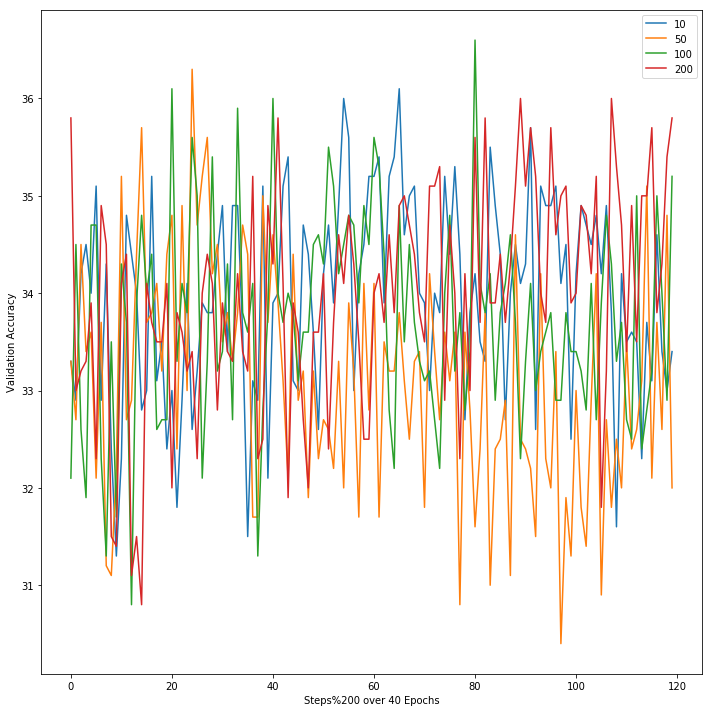

In [32]:
fig = plt.figure(figsize = (10,10))

plt.plot(hidden_size_plotting)
plt.xlabel("Steps%200 over 40 Epochs")
plt.ylabel("Validation Accuracy")
plt.legend([10, 50, 100, 200], loc='best')
plt.tight_layout()
plt.savefig('hidden_size_rnn.png', dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize = (10,10))

plt.plot(hidden_size_train_plotting)
plt.xlabel("Steps%200 over 40 Epochs")
plt.ylabel("Training Accuracy")
plt.legend([10, 50, 100, 200], loc='best')
plt.tight_layout()
plt.savefig('hidden_size_rnn_train.png', dpi=300)
plt.show()

In [ ]:
model = RNN(emb_size=300, hidden_size=200, num_layers=1, num_classes=3)

learning_rate = 3e-4
num_epochs = 30

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(mini_train_loader)

for epoch in range(num_epochs):
    for i, (data1, data2, lengths, lengths2, labels) in enumerate(mini_train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.long(), data2.long(), lengths, lengths2)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 250 iterations
        if i > 0 and i % 20 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(mini_train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Training Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(mini_train_loader), val_acc, train_acc))

## CNN Model

In [34]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, kernel_size=3):
        super(CNN, self).__init__()
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(loaded_embeddings), freeze=True)

        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=1)
        
        self.fc = nn.Linear(2*hidden_size, num_classes)

    def init_hidden(self, batch_size):
        hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size)
        return hidden

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        batch_size, seq_len = x1.size()

        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)

        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)

        self.hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        self.hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        
        self.hidden1 = F.relu(self.hidden1.contiguous().view(-1, self.hidden1.size(-1))).view(batch_size, seq_len, self.hidden1.size(-1))
        self.hidden2 = F.relu(self.hidden2.contiguous().view(-1, self.hidden2.size(-1))).view(batch_size, seq_len, self.hidden2.size(-1))

        self.hidden1 = self.conv2(self.hidden1.transpose(1,2)).transpose(1,2)
        self.hidden2 = self.conv2(self.hidden2.transpose(1,2)).transpose(1,2)
        
        self.hidden1 = F.relu(self.hidden1.contiguous().view(-1, self.hidden1.size(-1))).view(batch_size, seq_len, self.hidden1.size(-1))
        self.hidden2 = F.relu(self.hidden2.contiguous().view(-1, self.hidden2.size(-1))).view(batch_size, seq_len, self.hidden2.size(-1))
        
        self.hidden1 = torch.sum(self.hidden1, dim=1)
        self.hidden2 = torch.sum(self.hidden2, dim=1)
        
        concatenated = torch.cat([self.hidden1, self.hidden2], dim=1)
        logits = self.fc(concatenated)
        return logits

In [ ]:
cnn_hidden_size_plotting=pd.DataFrame()
cnn_hidden_size_train_plotting=pd.DataFrame()

for k in [10, 50, 100, 200]:
    model = CNN(emb_size=300, hidden_size=k, num_layers=1, num_classes=3)

    learning_rate = 3e-4
    num_epochs = 40

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_step = len(quarter_train_loader)
    val_accuracy = []
    train_accuracy = []
    for epoch in range(num_epochs):
        for i, (data1, data2, lengths, lengths2, labels) in enumerate(quarter_train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1.long(), data2.long(), lengths, lengths2)
            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 250 iterations
            if i > 0 and i % 200 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(quarter_train_loader, model)
                val_accuracy.append(val_acc)
                train_accuracy.append(train_acc)
        print('Epoch: [{}/{}], Validation Acc: {}, Training Acc: {}'.format(
                           epoch+1, num_epochs, val_acc, train_acc))
    cnn_hidden_size_plotting[str(k)] = pd.Series(val_accuracy)
    cnn_hidden_size_train_plotting[str(k)] = pd.Series(train_accuracy)

Epoch: [1/40], Validation Acc: 33.1, Training Acc: 33.865
Epoch: [2/40], Validation Acc: 34.4, Training Acc: 34.22
Epoch: [3/40], Validation Acc: 34.4, Training Acc: 33.8
Epoch: [4/40], Validation Acc: 34.0, Training Acc: 36.055
Epoch: [5/40], Validation Acc: 33.7, Training Acc: 34.5
Epoch: [6/40], Validation Acc: 35.7, Training Acc: 35.69
Epoch: [7/40], Validation Acc: 35.5, Training Acc: 35.915
Epoch: [8/40], Validation Acc: 30.1, Training Acc: 38.065
Epoch: [9/40], Validation Acc: 31.9, Training Acc: 35.67
Epoch: [10/40], Validation Acc: 34.3, Training Acc: 37.92
Epoch: [11/40], Validation Acc: 31.6, Training Acc: 37.865
Epoch: [12/40], Validation Acc: 32.1, Training Acc: 39.245
Epoch: [13/40], Validation Acc: 32.8, Training Acc: 39.69
Epoch: [14/40], Validation Acc: 31.7, Training Acc: 40.17
Epoch: [15/40], Validation Acc: 32.7, Training Acc: 42.02
Epoch: [16/40], Validation Acc: 34.7, Training Acc: 40.745
Epoch: [17/40], Validation Acc: 32.7, Training Acc: 43.26
Epoch: [18/40], Va

In [ ]:
fig = plt.figure(figsize = (10,10))

plt.plot(cnn_hidden_size_plotting)
plt.xlabel("Steps%200 over 40 Epochs")
plt.ylabel("Validation Accuracy")
plt.legend([10, 50, 100, 200], loc='best')
plt.tight_layout()
plt.savefig('hidden_size_cnn.png', dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize = (10,10))

plt.plot(cnn_hidden_size_train_plotting)
plt.xlabel("Steps%200 over 40 Epochs")
plt.ylabel("Training Accuracy")
plt.legend([10, 50, 100, 200], loc='best')
plt.tight_layout()
plt.savefig('hidden_size_train_cnn.png', dpi=300)
plt.show()

In [ ]:
kernel_size_plotting=pd.DataFrame()
kernel_size_train_plotting=pd.DataFrame()

for k in [1, 3, 5]:
    model = CNN(emb_size=300, hidden_size=100, num_layers=1, num_classes=3, kernel_size = k)

    learning_rate = 3e-4
    num_epochs = 40

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_step = len(quarter_train_loader)
    val_accuracy = []
    train_accuracy = []
    for epoch in range(num_epochs):
        for i, (data1, data2, lengths, lengths2, labels) in enumerate(quarter_train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1.long(), data2.long(), lengths, lengths2)
            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 250 iterations
            if i > 0 and i % 200 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(quarter_train_loader, model)
                val_accuracy.append(val_acc)
                train_accuracy.append(train_acc)
        print('Epoch: [{}/{}], Validation Acc: {}, Training Acc: {}'.format(
                           epoch+1, num_epochs, val_acc, train_acc))
    kernel_size_plotting[str(k)] = pd.Series(val_accuracy)
    kernel_size_train_plotting[str(k)] = pd.Series(train_accuracy)

In [ ]:
fig = plt.figure(figsize = (10,10))

plt.plot(kernel_size_plotting)
plt.xlabel("Steps%200 over 40 Epochs")
plt.ylabel("Validation Accuracy")
plt.legend([1, 3, 5], loc='best')
plt.tight_layout()
plt.savefig('kernel_size.png', dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize = (10,10))

plt.plot(kernel_size_train_plotting)
plt.xlabel("Steps%200 over 40 Epochs")
plt.ylabel("Training Accuracy")
plt.legend([1, 3, 5], loc='best')
plt.tight_layout()
plt.savefig('kernel_size_train.png', dpi=300)
plt.show()